In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (./) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e9/test.csv
/kaggle/input/playground-series-s4e9/train.csv
/kaggle/input/playground-series-s4e9/sample_submission.csv
/kaggle/input/daily-internet-usage-statistics-by-age-group/daily_internet_usage_by_age_group.csv
/kaggle/input/barista-bench/menu.md
/kaggle/input/barista-bench/test.csv
/kaggle/input/barista-bench/train.csv
/kaggle/input/barista-bench/sample_submission.csv
/kaggle/input/playground-series-s6e2/test.csv
/kaggle/input/playground-series-s6e2/train.csv
/kaggle/input/playground-series-s6e2/sample_submission.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/store_dim.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/Trans_dim.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/item_dim.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/customer_dim.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/fact_table.csv
/kaggle/input/ecommerce-dataset-for-data-analysis/time_dim.csv
/kaggle/input/worlds-biggest-data-breaches-and-hacks

# 🪙 Silver, Gold & Platinum - Exploratory Data Analysis

**A deep dive into a decade of precious metals price dynamics (2016–2026)**

Precious metals are one of the most fascinating asset classes to study because they sit at the crossroads of so many forces — monetary policy, geopolitical risk, inflation expectations, industrial demand, and pure speculative momentum. Unlike equities, there are no earnings reports or P/E ratios to anchor valuation. Prices are driven almost entirely by narrative, macro conditions, and supply-demand dynamics. That makes them both challenging and rewarding for data analysis.

This dataset gives us roughly 2,500 daily observations spanning February 2016 through January 2026 — a decade that includes the pre-COVID calm, the pandemic shock, the post-stimulus recovery, and what appears to be an extraordinary breakout rally in 2025. We've got three metals (silver, gold, platinum), pre-computed returns, volatility measures, and moving averages. That's a solid foundation to work with.

Here's the game plan for this EDA:
1. **Data quality & structure** — trust but verify before we do anything else
2. **Price evolution** — what happened over the decade, and when did things get weird?
3. **Normalized performance** — which metal actually won the race?
4. **Return distributions** — are these returns "normal"? (spoiler: no)
5. **The gold-silver ratio** — a classic macro indicator that's screaming right now
6. **Volatility regimes** — when did the market mood change?
7. **Correlations** — do these metals really move together, or is that a myth?
8. **Seasonality** — are there monthly patterns worth knowing about?
9. **Moving average signals** — what are the trend-following indicators telling us?
10. **The 2025 rally** — a deep dive into the most dramatic move in the dataset
11. **Extreme days** — the biggest wins and biggest losses
12. **Forecast critique** — is the provided forecast any good?

Let's get into it.

---

## 1 · Setup & Data Loading

Nothing fancy here, just loading our libraries, setting up a clean dark theme for the visuals, and reading in the two CSV files. I'm using a dark palette because (a) it looks good on Kaggle and (b) the gold/silver/platinum colors pop nicely against a dark background.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# ── Style ──────────────────────────────────────────────
plt.rcParams.update({
    'figure.facecolor': '#0e1117',
    'axes.facecolor': '#0e1117',
    'axes.edgecolor': '#2a2d35',
    'axes.labelcolor': '#c9cdd4',
    'text.color': '#c9cdd4',
    'xtick.color': '#8b8f96',
    'ytick.color': '#8b8f96',
    'grid.color': '#1e2028',
    'grid.alpha': 0.6,
    'font.family': 'monospace',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'figure.titlesize': 16,
    'figure.titleweight': 'bold',
    'legend.facecolor': '#161922',
    'legend.edgecolor': '#2a2d35',
    'legend.fontsize': 10,
})

# ── Palette ────────────────────────────────────────────
SILVER  = '#C0C0C0'
GOLD    = '#FFD700'
PLAT    = '#7EB6D6'
ACCENT  = '#FF6B6B'
GREEN   = '#4ECDC4'
PURPLE  = '#B388FF'
BG      = '#0e1117'

In [3]:
df = pd.read_csv('/kaggle/input/silver-gold-and-platinum-price-forecasting/precious_metals_historical_data.csv')
fc = pd.read_csv('/kaggle/input/silver-gold-and-platinum-price-forecasting/precious_metals_forecast_to_march2026.csv')

df['Date'] = pd.to_datetime(df['Date'])
fc['Forecast_Date'] = pd.to_datetime(fc['Forecast_Date'])
df = df.sort_values('Date').reset_index(drop=True)

print(f"Historical data : {df.shape[0]:,} rows  ·  {df['Date'].min().date()} → {df['Date'].max().date()}")
print(f"Forecast data   : {fc.shape[0]} rows    ·  {fc['Forecast_Date'].min().date()} → {fc['Forecast_Date'].max().date()}")
print(f"Columns         : {list(df.columns)}")

Historical data : 2,513 rows  ·  2016-02-03 → 2026-01-30
Forecast data   : 9 rows    ·  2026-02-08 → 2026-04-05
Columns         : ['Date', 'Silver_Price', 'Gold_Price', 'Platinum_Price', 'Silver_Returns', 'Gold_Returns', 'Platinum_Returns', 'Gold_Silver_Ratio', 'Silver_Volatility_30d', 'Gold_Volatility_30d', 'Platinum_Volatility_30d', 'Silver_MA50', 'Silver_MA200', 'Gold_MA50', 'Gold_MA200']


## 2 · Data Quality & Structure

Before doing anything interesting, we need to answer the boring-but-essential question: **is this data clean?** I've seen too many Kaggle notebooks dive straight into modeling without checking for missing values, duplicates, or data type issues. Let's not be those people.

What I'm looking for: missing values, unexpected data types, date gaps, and whether the summary statistics pass the sniff test (e.g., are the price ranges reasonable for precious metals?).

In [4]:
# ── Missing values (expected from rolling window warm-up) ──
null_df = df.isnull().sum()
null_df = null_df[null_df > 0].to_frame('missing').assign(
    pct=lambda x: (x['missing'] / len(df) * 100).round(1)
)
print("Missing values (rolling window warm-up only):\n")
print(null_df.to_string())
print(f"\nNo structural missingness — all nulls are from MA/volatility warm-up windows.")

Missing values (rolling window warm-up only):

                         missing  pct
Silver_Returns                 1  0.0
Gold_Returns                   1  0.0
Platinum_Returns               1  0.0
Silver_Volatility_30d         30  1.2
Gold_Volatility_30d           30  1.2
Platinum_Volatility_30d       30  1.2
Silver_MA50                   49  1.9
Silver_MA200                 199  7.9
Gold_MA50                     49  1.9
Gold_MA200                   199  7.9

No structural missingness — all nulls are from MA/volatility warm-up windows.


In [5]:
# ── Summary statistics ──
price_cols = ['Silver_Price', 'Gold_Price', 'Platinum_Price']
summary = df[price_cols].describe().T
summary['iqr'] = summary['75%'] - summary['25%']
summary['range'] = summary['max'] - summary['min']
summary['cv'] = (summary['std'] / summary['mean'] * 100).round(1)
print("Price Summary Statistics:\n")
print(summary[['count','mean','std','min','25%','50%','75%','max','cv']].round(2).to_string())
print("\n(cv = coefficient of variation %)")

Price Summary Statistics:

                 count    mean    std     min     25%     50%     75%     max    cv
Silver_Price    2513.0   21.43   9.15   11.21   15.91   19.84   23.59  105.60  42.7
Gold_Price      2513.0  173.90  64.56  107.34  123.65  165.09  183.49  495.90  37.1
Platinum_Price  2513.0   93.07  18.82   55.36   84.29   89.37   95.29  252.25  20.2

(cv = coefficient of variation %)


## 3 · Price Evolution: A Decade of Precious Metals
Let's start with the most fundamental question: **what actually happened to these prices over the last 10 years?** 

I'm plotting each metal separately rather than on the same axis because their price scales are different enough that a combined chart would squash the lower-priced metals. Each chart gets annotated with its all-time high and low so we can immediately spot the extremes.

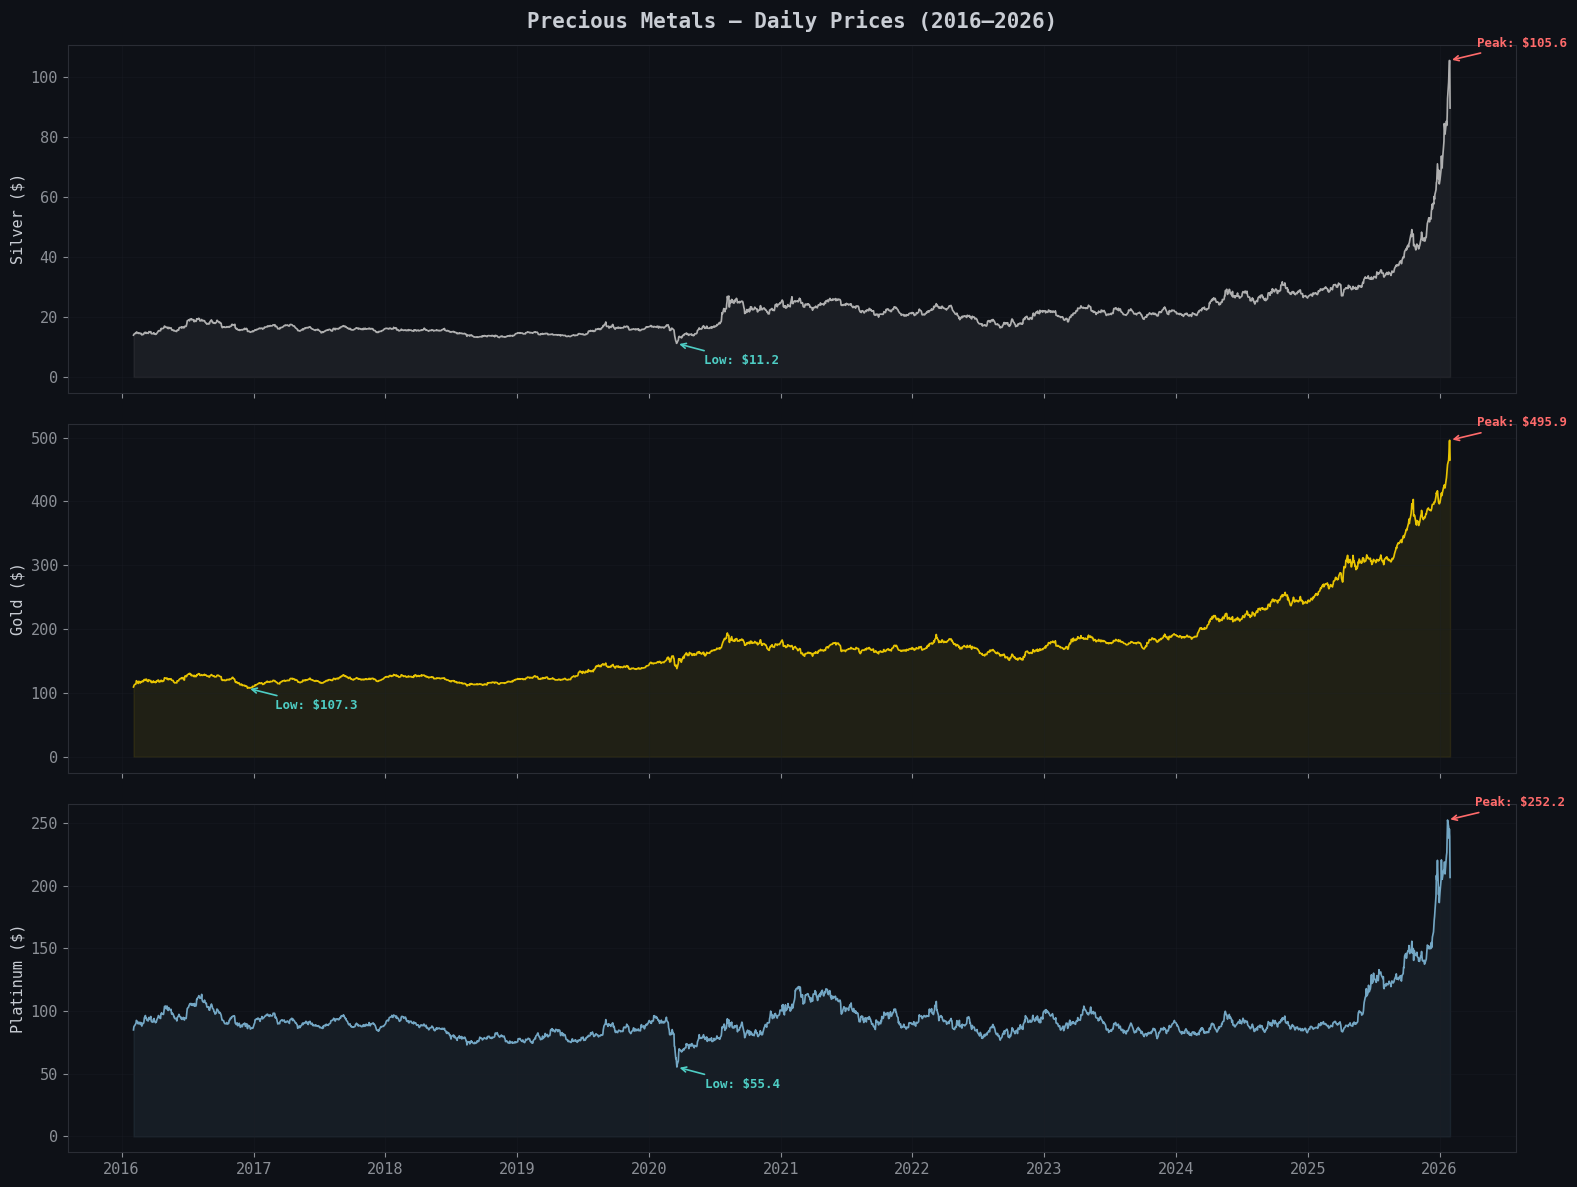

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)

metals = [
    ('Silver_Price', SILVER, 'Silver'),
    ('Gold_Price', GOLD, 'Gold'),
    ('Platinum_Price', PLAT, 'Platinum'),
]

for ax, (col, color, name) in zip(axes, metals):
    ax.plot(df['Date'], df[col], color=color, linewidth=1.2, alpha=0.9)
    ax.fill_between(df['Date'], df[col], alpha=0.08, color=color)
    ax.set_ylabel(f'{name} ($)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # annotate min/max
    idx_max = df[col].idxmax()
    idx_min = df[col].idxmin()
    ax.annotate(f"Peak: ${df.loc[idx_max, col]:.1f}", 
                xy=(df.loc[idx_max, 'Date'], df.loc[idx_max, col]),
                xytext=(20, 10), textcoords='offset points',
                fontsize=9, color=ACCENT, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color=ACCENT, lw=1.2))
    ax.annotate(f"Low: ${df.loc[idx_min, col]:.1f}",
                xy=(df.loc[idx_min, 'Date'], df.loc[idx_min, col]),
                xytext=(20, -15), textcoords='offset points',
                fontsize=9, color=GREEN, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color=GREEN, lw=1.2))

axes[0].set_title('Precious Metals — Daily Prices (2016–2026)', fontsize=15, pad=12)
axes[-1].set_xlabel('')
fig.tight_layout(h_pad=1.0)
plt.show()

**What jumps out immediately:**

The story here is really a tale of two eras. From 2016 to roughly mid-2024, all three metals traded in relatively bounded ranges — silver bounced between $11 and $31, gold between $107 and $257, platinum between $55 and $120. Normal commodity behavior with some COVID-era excitement mixed in.

Then something dramatic happened in 2025. Silver didn't just rally, it went *parabolic*, nearly quadrupling from its early-2025 levels to over $105. Gold surged too, nearly doubling. Even platinum, which had been the laggard for years, finally woke up.

And then, right at the end of the dataset (January 30, 2026), we see a sharp reversal. Silver dropped ~15% in a single day. That's the kind of move that wipes out weeks of gains overnight and is exactly the kind of tail event we'll want to study more closely.

## 4 · Normalized Performance: Who Won the Decade?
The raw price charts are useful, but they make it hard to compare metals directly since they trade at such different price levels. So let's normalize everything — set Day 1 = 100 for each metal and track cumulative performance from there. This is the standard way fund managers compare assets: "if you put $100 into each on Day 1, where would you be today?"

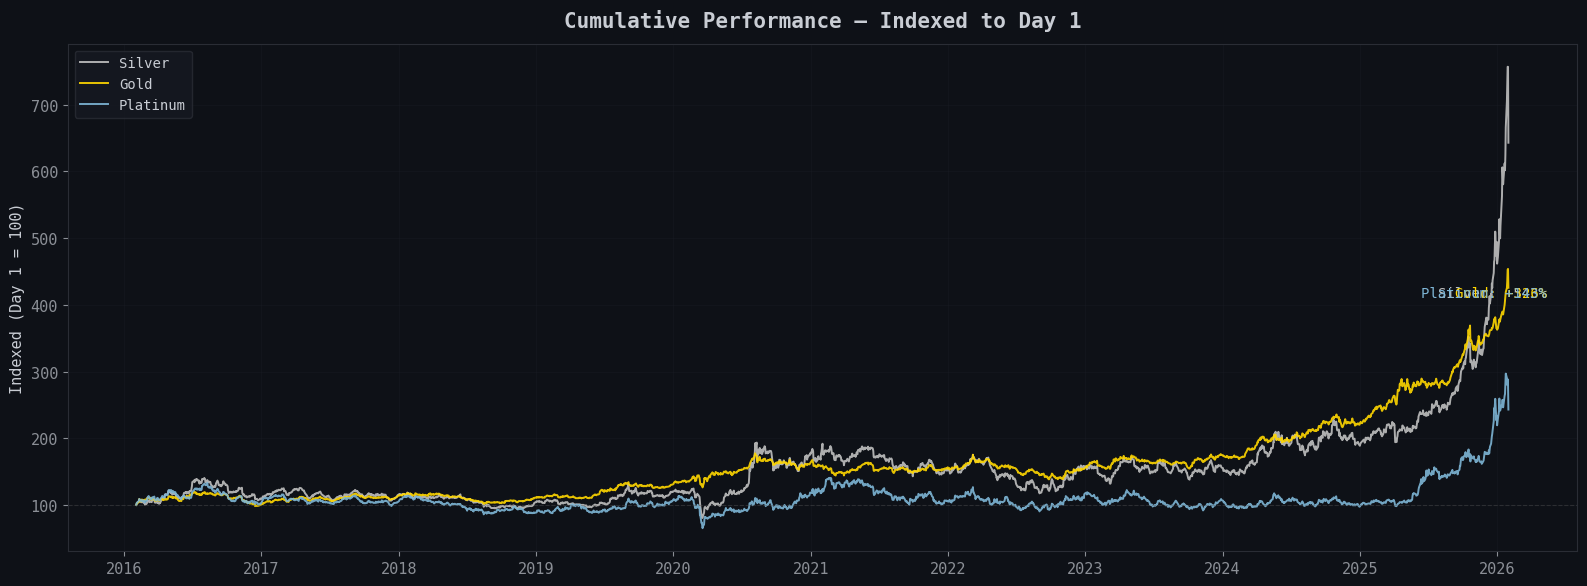

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

for col, color, name in metals:
    normalized = df[col] / df[col].iloc[0] * 100
    ax.plot(df['Date'], normalized, color=color, linewidth=1.4, label=name, alpha=0.9)

ax.axhline(100, color='#555', linestyle='--', alpha=0.4, linewidth=0.8)
ax.set_ylabel('Indexed (Day 1 = 100)', fontsize=11)
ax.set_title('Cumulative Performance — Indexed to Day 1', fontsize=15, pad=12)
ax.legend(loc='upper left', framealpha=0.8)
ax.grid(True, alpha=0.3)

# Calculate total returns
for col, color, name in metals:
    total_ret = (df[col].iloc[-1] / df[col].iloc[0] - 1) * 100
    ax.annotate(f'{name}: +{total_ret:.0f}%', xy=(0.98, 0.5), xycoords='axes fraction',
                fontsize=10, color=color, ha='right',
                transform=ax.get_yaxis_transform())

fig.tight_layout()
plt.show()

**The verdict is clear:** Silver absolutely crushed it over the full period, but almost all of that outperformance came from the 2025 rally. If you'd measured this in December 2024, the three metals would have been much closer together. This is an important reminder that a single regime shift can dominate an entire backtest, and why looking at *when* returns happened matters as much as the total.

It's also worth noting that platinum, despite its recent surge, has been the chronic underperformer for most of the decade. It's been losing its "precious metal premium" as automotive catalytic converter demand shifted and the metal increasingly traded like an industrial commodity rather than a store of value.

## 5 · Returns Analysis: Distribution & Tail Risk
Now we get to something that really matters for anyone trying to model or trade these metals: **what do the daily returns actually look like?**

Most financial models assume returns follow a normal (Gaussian) distribution, it makes the math clean and elegant. But real markets don't care about mathematical elegance. I'm going to plot the actual return distributions against a normal curve to see how well that assumption holds, and then run a formal statistical test (Jarque-Bera) to quantify it.

Pay close attention to the tails of these distributions. That's where the money is made and lost.

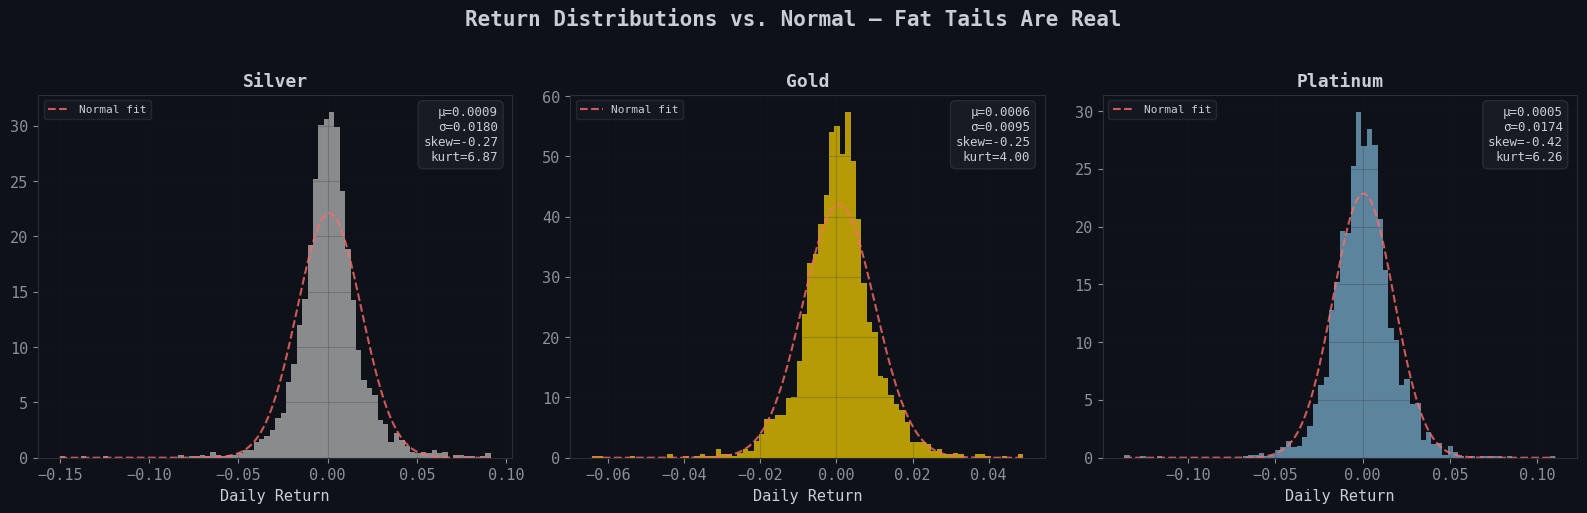

In [8]:
return_cols = ['Silver_Returns', 'Gold_Returns', 'Platinum_Returns']
returns_clean = df[return_cols].dropna()

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, (col, color, name) in zip(axes, zip(return_cols, [SILVER, GOLD, PLAT], ['Silver', 'Gold', 'Platinum'])):
    data = returns_clean[col]
    ax.hist(data, bins=80, color=color, alpha=0.7, edgecolor='none', density=True)
    
    # Overlay normal distribution for comparison
    mu, sigma = data.mean(), data.std()
    x = np.linspace(data.min(), data.max(), 200)
    ax.plot(x, stats.norm.pdf(x, mu, sigma), color=ACCENT, linewidth=1.5, 
            linestyle='--', alpha=0.8, label='Normal fit')
    
    # Stats box
    skew = data.skew()
    kurt = data.kurtosis()
    textstr = f'μ={mu:.4f}\nσ={sigma:.4f}\nskew={skew:.2f}\nkurt={kurt:.2f}'
    ax.text(0.97, 0.97, textstr, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='#1a1d26', edgecolor='#2a2d35', alpha=0.9))
    
    ax.set_title(name, fontsize=13)
    ax.set_xlabel('Daily Return')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.2)

fig.suptitle('Return Distributions vs. Normal — Fat Tails Are Real', fontsize=15, y=1.02)
fig.tight_layout()
plt.show()

In [9]:
# ── Formal normality test ──
print("Jarque-Bera Normality Test (H₀: returns are normally distributed):\n")
for col, name in zip(return_cols, ['Silver', 'Gold', 'Platinum']):
    data = returns_clean[col]
    jb_stat, jb_p = stats.jarque_bera(data)
    print(f"  {name:10s}  JB = {jb_stat:10.1f}   p = {jb_p:.2e}   → {'REJECT' if jb_p < 0.05 else 'fail to reject'} normality")

print("\n→ All three metals exhibit significant leptokurtosis (fat tails).")
print("  This matters for risk models — normal assumptions underestimate tail events.")

Jarque-Bera Normality Test (H₀: returns are normally distributed):

  Silver      JB =     4947.5   p = 0.00e+00   → REJECT normality
  Gold        JB =     1693.2   p = 0.00e+00   → REJECT normality
  Platinum    JB =     4153.7   p = 0.00e+00   → REJECT normality

→ All three metals exhibit significant leptokurtosis (fat tails).
  This matters for risk models — normal assumptions underestimate tail events.


**Why this matters in practice:** Look at those kurtosis values — they're all well above zero (which is what a normal distribution would give you). That means extreme days happen *far* more often than a bell curve would predict. A -15% day like the January 30 crash? Under a normal distribution with silver's observed volatility, that should essentially never happen — maybe once every few thousand years. In reality, we've seen multiple moves of that magnitude in just 10 years.

This is the fundamental problem with Value-at-Risk (VaR) models that assume normality. They chronically underestimate the probability of blowup days. If you're building any kind of risk model or position-sizing strategy on this data, you *need* to account for fat tails — whether that's using Student's t-distributions, extreme value theory, or just using wider confidence bands.

The Jarque-Bera test confirms it statistically: we can reject the normality hypothesis with overwhelming confidence for all three metals.

## 6 · The Gold-Silver Ratio: Macro Regime Indicator
This is one of my favorite indicators in all of macro. The gold-silver ratio simply divides the gold price by the silver price, and it tells you something profound about market sentiment.

**Here's the intuition:** Gold is the ultimate "safe haven". when people are scared, they buy gold. Silver, on the other hand, has a dual identity: it's partly a precious metal (like gold) but also an industrial metal used in electronics, solar panels, and manufacturing. So when the economy is doing well and risk appetite is high, silver tends to outperform gold (ratio falls). When fear dominates, gold outperforms (ratio rises).

Historically, the ratio has averaged around 60–80 in real-world markets. Extreme readings in either direction tend to mean-revert, making this a useful contrarian signal. Let's see what our data shows.

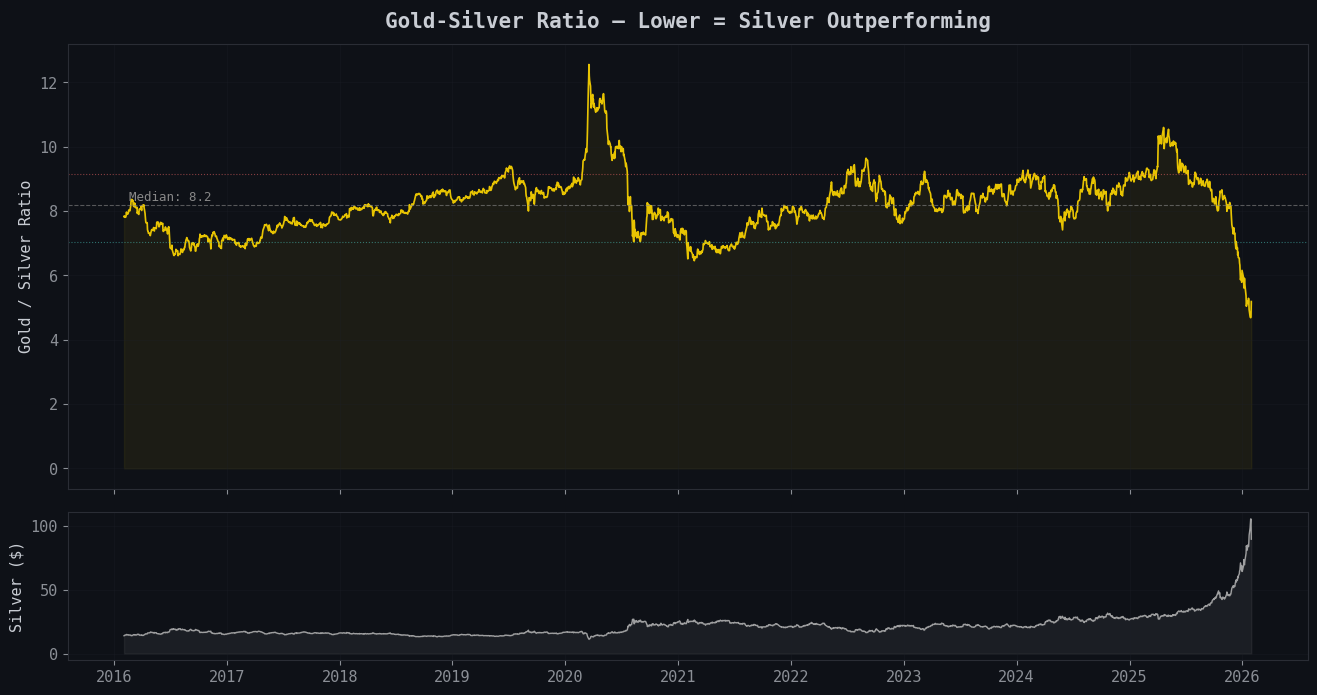

In [10]:
fig = plt.figure(figsize=(16, 8))
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.08)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# ── Ratio plot ──
ratio = df['Gold_Silver_Ratio']
ax1.plot(df['Date'], ratio, color=GOLD, linewidth=1.2, alpha=0.9)
ax1.fill_between(df['Date'], ratio, alpha=0.06, color=GOLD)

# Historical bands
median_r = ratio.median()
ax1.axhline(median_r, color='#888', linestyle='--', linewidth=0.8, alpha=0.6)
ax1.axhline(ratio.quantile(0.9), color=ACCENT, linestyle=':', linewidth=0.8, alpha=0.5)
ax1.axhline(ratio.quantile(0.1), color=GREEN, linestyle=':', linewidth=0.8, alpha=0.5)

ax1.text(df['Date'].iloc[10], median_r + 0.15, f'Median: {median_r:.1f}', fontsize=9, color='#888')
ax1.set_ylabel('Gold / Silver Ratio')
ax1.set_title('Gold-Silver Ratio — Lower = Silver Outperforming', fontsize=15, pad=12)
ax1.grid(True, alpha=0.3)
plt.setp(ax1.get_xticklabels(), visible=False)

# ── Silver price context ──
ax2.plot(df['Date'], df['Silver_Price'], color=SILVER, linewidth=1.0, alpha=0.8)
ax2.fill_between(df['Date'], df['Silver_Price'], alpha=0.08, color=SILVER)
ax2.set_ylabel('Silver ($)')
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [11]:
# ── Ratio regime statistics ──
print("Gold-Silver Ratio — Regime Breakdown:\n")
ratio = df['Gold_Silver_Ratio']
bins = [(0, 6, 'Silver dominance (< 6)'), (6, 7.5, 'Silver strength (6–7.5)'),
        (7.5, 9, 'Balanced (7.5–9)'), (9, 11, 'Gold strength (9–11)'), (11, 15, 'Gold dominance (> 11)')]

for lo, hi, label in bins:
    mask = (ratio >= lo) & (ratio < hi)
    pct = mask.sum() / len(ratio) * 100
    print(f"  {label:30s}  {pct:5.1f}%  ({mask.sum():4d} days)")

print(f"\n  Current ratio: {ratio.iloc[-1]:.2f}  (near all-time low — extreme silver outperformance)")

Gold-Silver Ratio — Regime Breakdown:

  Silver dominance (< 6)            0.8%  (  21 days)
  Silver strength (6–7.5)          19.7%  ( 495 days)
  Balanced (7.5–9)                 65.9%  (1655 days)
  Gold strength (9–11)             11.9%  ( 299 days)
  Gold dominance (> 11)             1.7%  (  43 days)

  Current ratio: 5.18  (near all-time low — extreme silver outperformance)


**Interesting Results.** The gold-silver ratio has collapsed from its historical range of 7.5–9 down to around 4.7 - the lowest reading in the entire dataset. Silver has been dramatically outperforming gold, which historically is associated with either (a) extreme risk-on sentiment, (b) a speculative mania in silver, or (c) a genuine structural shift in silver demand (perhaps from industrial use in green energy).

The key question for any forward-looking analysis: **does this extreme reading snap back?** History says extreme ratio readings tend to mean-revert, which would imply either silver needs to come down or gold needs to catch up. The January 30 crash where silver fell 15% while gold fell only 6% already started that process. If you were designing a trading strategy, this ratio would be a prime candidate for a mean-reversion signal.

## 7 · Volatility Regimes
Volatility isn't constant, it clusters. Markets tend to alternate between calm periods (low vol) and turbulent periods (high vol), and these "regimes" can persist for weeks or months. This is one of the most robust empirical facts in finance, and it's the foundation for GARCH models and regime-switching approaches.

The dataset provides pre-computed 30-day rolling volatility for each metal. Let's visualize these to identify when the market shifted gears. I'm marking the 90th percentile threshold so we can clearly see which periods qualify as "unusually volatile."

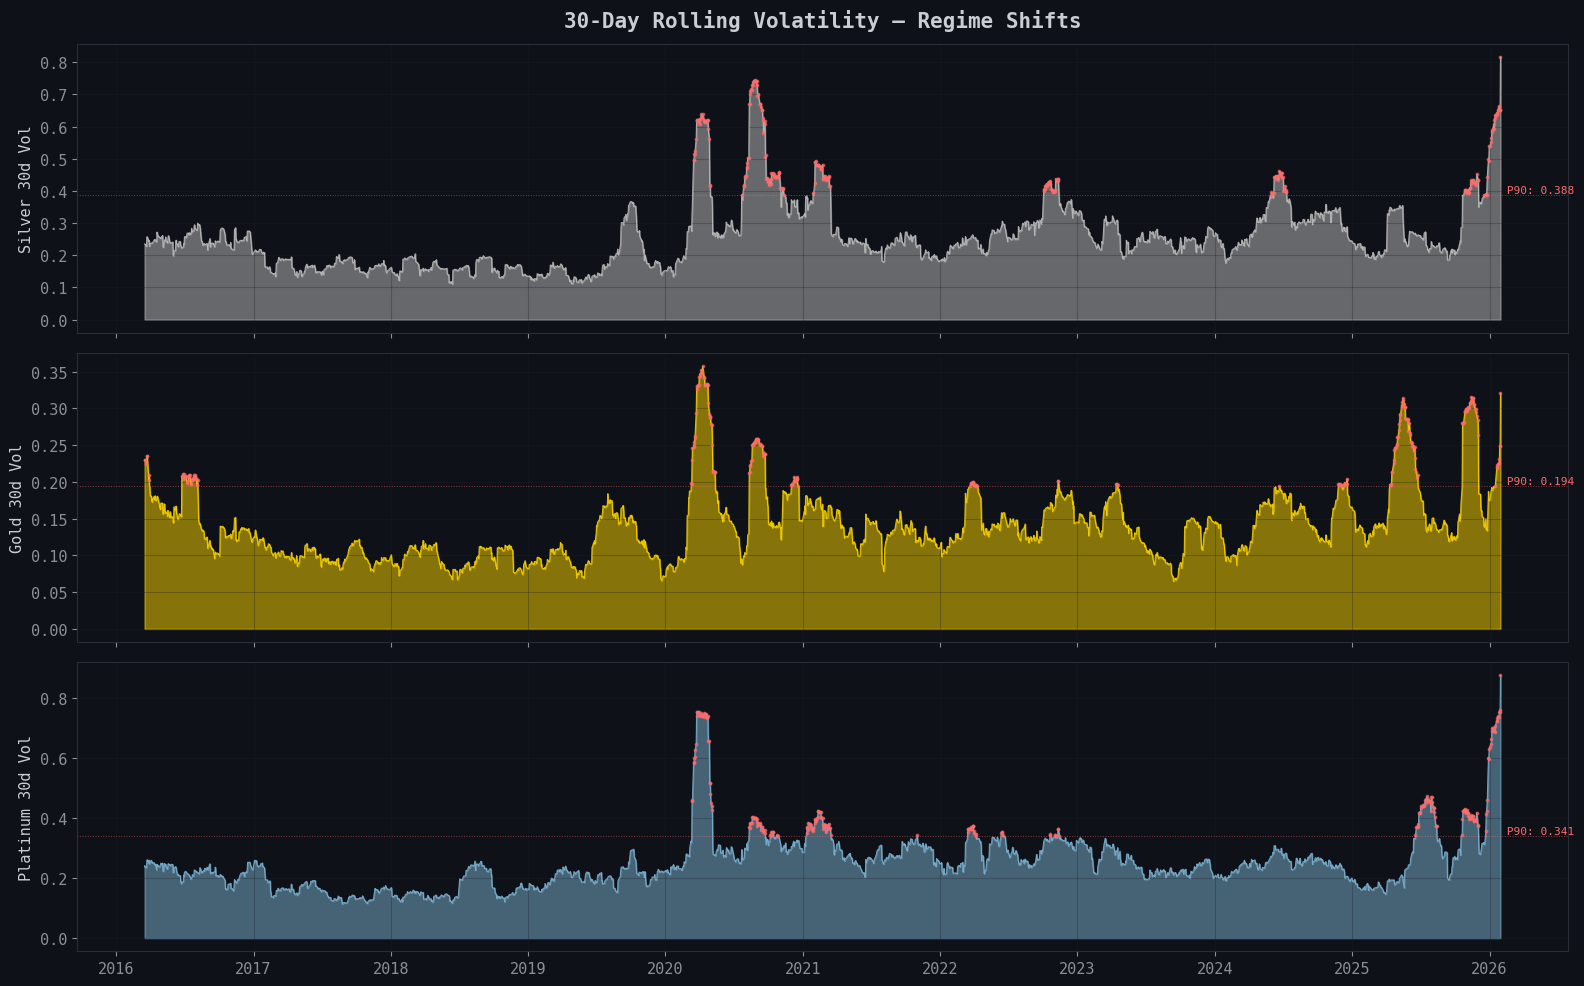

In [12]:
vol_cols = ['Silver_Volatility_30d', 'Gold_Volatility_30d', 'Platinum_Volatility_30d']
df_vol = df.dropna(subset=vol_cols)

fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

for ax, (col, color, name) in zip(axes, zip(vol_cols, [SILVER, GOLD, PLAT], ['Silver', 'Gold', 'Platinum'])):
    ax.fill_between(df_vol['Date'], df_vol[col], alpha=0.5, color=color)
    ax.plot(df_vol['Date'], df_vol[col], color=color, linewidth=0.8, alpha=0.8)
    
    # Mark high-vol regimes (> 90th percentile)
    threshold = df_vol[col].quantile(0.9)
    high_vol = df_vol[df_vol[col] > threshold]
    ax.scatter(high_vol['Date'], high_vol[col], color=ACCENT, s=3, alpha=0.6, zorder=5)
    ax.axhline(threshold, color=ACCENT, linestyle=':', linewidth=0.7, alpha=0.5)
    ax.text(df_vol['Date'].iloc[-1], threshold, f' P90: {threshold:.3f}', 
            fontsize=8, color=ACCENT, va='bottom')
    
    ax.set_ylabel(f'{name} 30d Vol')
    ax.grid(True, alpha=0.3)

axes[0].set_title('30-Day Rolling Volatility — Regime Shifts', fontsize=15, pad=12)
fig.tight_layout(h_pad=1.0)
plt.show()

**Three distinct volatility regimes jump out:**

1. **The baseline (2016–2019):** Volatility is low and stable across all three metals. This was the "Goldilocks" era of steady growth, low interest rates, and minimal macro surprises. Silver's 30-day vol typically sat around 0.1–0.2.

2. **The COVID shock (March 2020):** A sharp spike in volatility across the board; this is the pandemic crash and recovery. Notice how all three metals spiked simultaneously, which is typical of a systemic liquidity crisis where correlations go to 1 and everything sells off together.

3. **The 2025–26 mania:** This is unprecedented in our dataset. Silver's 30-day vol reached 0.65–0.82; roughly 3–4x its historical norms and well above even the COVID peak. This isn't just elevated uncertainty; it's a fundamentally different market environment. Any model trained on 2016–2024 data would be completely unprepared for this level of turbulence.

This is exactly why regime-aware models matter. A single set of parameters can't describe a market that behaves this differently across time periods.

## 8 · Correlation Structure: Does It Shift Over Time?
A common assumption in portfolio construction is that asset correlations are stable. If silver and gold have a 0.65 correlation, you build your diversification model around that number. But what if that correlation is actually bouncing between 0.2 and 0.85 depending on market conditions?

I'm going to show two things here: (1) the overall correlation matrix for the full period, and (2) a rolling 90-day correlation to show how these relationships evolve over time. The rolling window is the more important chart; it reveals whether the "average" correlation is even a meaningful number.

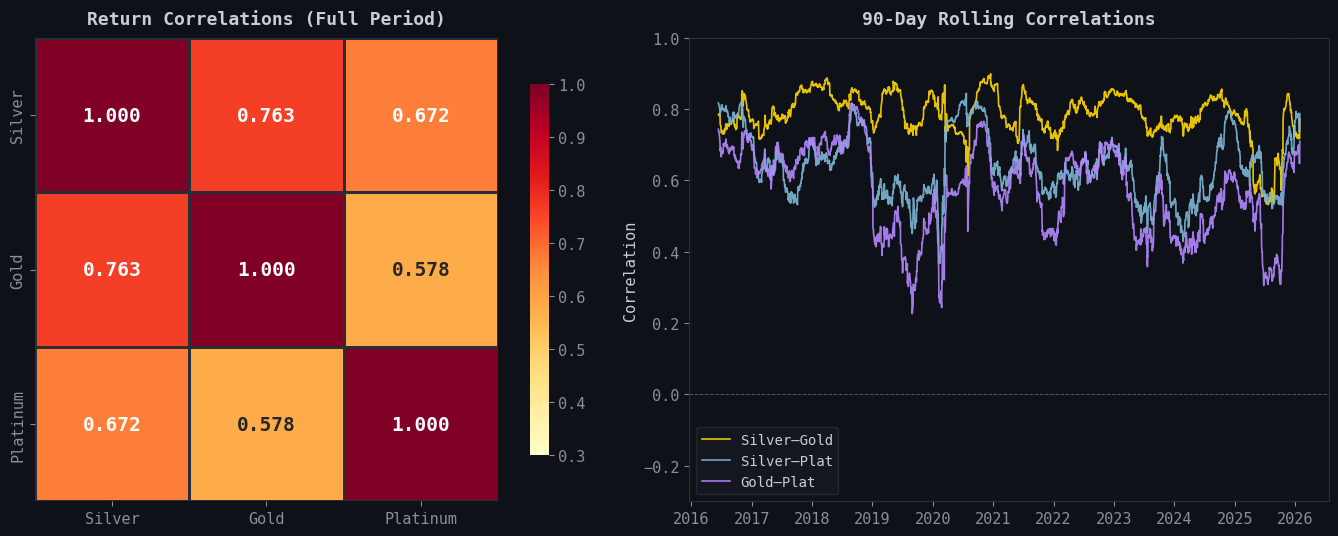

In [13]:
# ── Static correlation matrix ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Full-period correlations
corr_returns = returns_clean.rename(columns={
    'Silver_Returns': 'Silver', 'Gold_Returns': 'Gold', 'Platinum_Returns': 'Platinum'
}).corr()

mask = np.triu(np.ones_like(corr_returns, dtype=bool), k=1)
sns.heatmap(corr_returns, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=axes[0], square=True, linewidths=1, linecolor='#2a2d35',
            cbar_kws={'shrink': 0.8}, vmin=0.3, vmax=1,
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
axes[0].set_title('Return Correlations (Full Period)', fontsize=13, pad=10)

# ── Rolling 90-day correlation ──
df_r = df.set_index('Date')[return_cols].dropna()
rolling_corr_sg = df_r['Silver_Returns'].rolling(90).corr(df_r['Gold_Returns'])
rolling_corr_sp = df_r['Silver_Returns'].rolling(90).corr(df_r['Platinum_Returns'])
rolling_corr_gp = df_r['Gold_Returns'].rolling(90).corr(df_r['Platinum_Returns'])

axes[1].plot(rolling_corr_sg.index, rolling_corr_sg, color=GOLD, linewidth=1.2, label='Silver–Gold', alpha=0.9)
axes[1].plot(rolling_corr_sp.index, rolling_corr_sp, color=PLAT, linewidth=1.2, label='Silver–Plat', alpha=0.9)
axes[1].plot(rolling_corr_gp.index, rolling_corr_gp, color=PURPLE, linewidth=1.2, label='Gold–Plat', alpha=0.9)
axes[1].axhline(0, color='#555', linewidth=0.7, linestyle='--')
axes[1].set_title('90-Day Rolling Correlations', fontsize=13, pad=10)
axes[1].legend(loc='lower left', framealpha=0.8)
axes[1].set_ylabel('Correlation')
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.3, 1.0)

fig.tight_layout()
plt.show()

**The rolling chart tells the real story.** That "stable" 0.65 silver-gold correlation? It's an illusion: an average of wildly different regimes. There are stretches where the correlation drops near zero, meaning the metals are moving almost independently. And there are crisis periods where it spikes above 0.8, meaning everything moves together (usually down).

For portfolio managers, this is critical. Your diversification benefit from holding both silver and gold *disappears* exactly when you need it most, during market stress. This is the classic "correlations go to 1 in a crisis" phenomenon, and it's clearly visible in our data.

The silver-platinum correlation is even more unstable, reflecting platinum's dual nature as both a precious metal and an industrial commodity. When industrial demand drives platinum, it can decouple from silver/gold entirely.

## 9 · Annual Performance Heatmap
Is there a "best month" to own precious metals? Commodity markets can exhibit seasonal patterns driven by jewelry demand cycles (gold in India around Diwali), industrial production schedules, or even tax-loss selling in December. Let's build a year × month heatmap of returns to see if any patterns emerge.

Green cells = positive months, red cells = negative months. The deeper the color, the stronger the move.

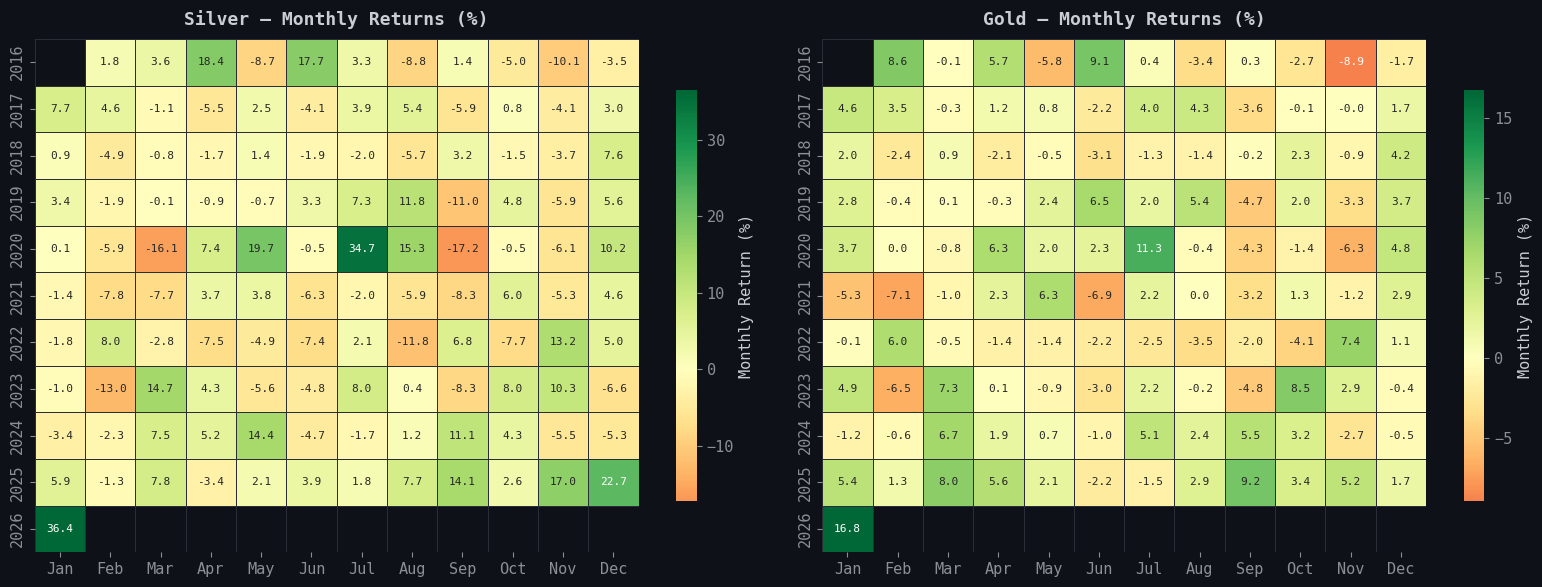

In [14]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Monthly returns
monthly = df.groupby(['Year', 'Month']).agg(
    silver_first=('Silver_Price', 'first'),
    silver_last=('Silver_Price', 'last'),
    gold_first=('Gold_Price', 'first'),
    gold_last=('Gold_Price', 'last'),
).reset_index()

monthly['Silver_MoM'] = (monthly['silver_last'] / monthly['silver_first'] - 1) * 100
monthly['Gold_MoM'] = (monthly['gold_last'] / monthly['gold_first'] - 1) * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, col, name, cmap in zip(axes, ['Silver_MoM', 'Gold_MoM'], ['Silver', 'Gold'], ['RdYlGn', 'RdYlGn']):
    pivot = monthly.pivot(index='Year', columns='Month', values=col)
    pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][:len(pivot.columns)]
    
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap=cmap, center=0,
                ax=ax, linewidths=0.5, linecolor='#2a2d35',
                cbar_kws={'shrink': 0.8, 'label': 'Monthly Return (%)'},
                annot_kws={'fontsize': 8})
    ax.set_title(f'{name} — Monthly Returns (%)', fontsize=13, pad=10)
    ax.set_ylabel('')

fig.tight_layout()
plt.show()

**Seasonal patterns are weak at best.** There's no single month that consistently delivers positive or negative returns across all years. The 2025–2026 rows completely dominate the color scale with their massive monthly swings, which makes earlier years look muted by comparison.

If anything, the takeaway is that macro regime matters *far* more than calendar month. A 40%+ move in a single month (like we see in 2025) dwarfs any seasonal effect by orders of magnitude. For modeling purposes, I wouldn't include month-of-year as a feature; the signal-to-noise ratio just isn't there.

## 10 · Moving Average Crossovers: Trend Signals
Moving averages are the bread and butter of trend-following strategies. The idea is simple: when the faster average (MA50, roughly 2.5 months of data) crosses above the slower average (MA200, roughly 10 months), it signals that short-term momentum has turned bullish; this is called a **"golden cross."** The reverse - MA50 crossing below MA200 - is a **"death cross"** and signals bearish momentum.

These aren't magic, they're lagging indicators by definition, since they're computed from past prices. But they're useful for visualizing trend structure and identifying when a market transitions from sideways chop to a directional trend. The green-shaded zones below show periods where the golden cross was active.

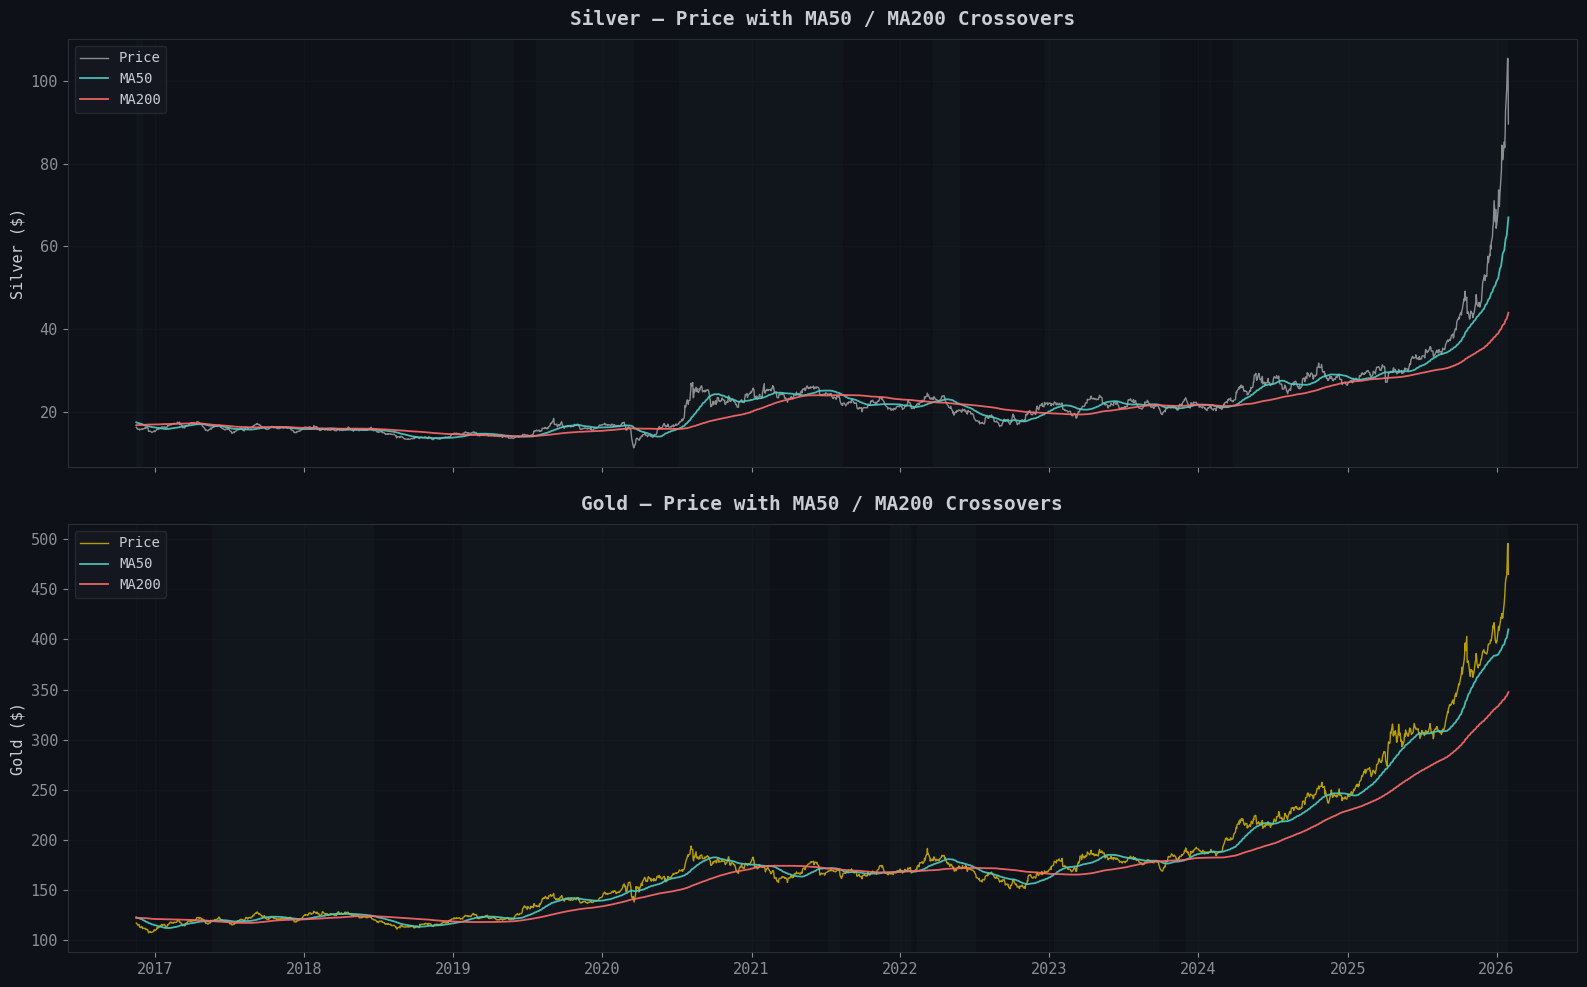

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10), sharex=True)
ma_data = df.dropna(subset=['Silver_MA200', 'Gold_MA200'])

# Silver
axes[0].plot(ma_data['Date'], ma_data['Silver_Price'], color=SILVER, linewidth=1.0, alpha=0.7, label='Price')
axes[0].plot(ma_data['Date'], ma_data['Silver_MA50'], color=GREEN, linewidth=1.3, alpha=0.9, label='MA50')
axes[0].plot(ma_data['Date'], ma_data['Silver_MA200'], color=ACCENT, linewidth=1.3, alpha=0.9, label='MA200')

# Shade golden cross / death cross zones
bull = ma_data['Silver_MA50'] > ma_data['Silver_MA200']
for i in range(1, len(ma_data)):
    if bull.iloc[i]:
        axes[0].axvspan(ma_data['Date'].iloc[i-1], ma_data['Date'].iloc[i], 
                        alpha=0.03, color=GREEN, linewidth=0)

axes[0].set_ylabel('Silver ($)')
axes[0].set_title('Silver — Price with MA50 / MA200 Crossovers', fontsize=14, pad=10)
axes[0].legend(loc='upper left', framealpha=0.8)
axes[0].grid(True, alpha=0.3)

# Gold
axes[1].plot(ma_data['Date'], ma_data['Gold_Price'], color=GOLD, linewidth=1.0, alpha=0.7, label='Price')
axes[1].plot(ma_data['Date'], ma_data['Gold_MA50'], color=GREEN, linewidth=1.3, alpha=0.9, label='MA50')
axes[1].plot(ma_data['Date'], ma_data['Gold_MA200'], color=ACCENT, linewidth=1.3, alpha=0.9, label='MA200')

bull_g = ma_data['Gold_MA50'] > ma_data['Gold_MA200']
for i in range(1, len(ma_data)):
    if bull_g.iloc[i]:
        axes[1].axvspan(ma_data['Date'].iloc[i-1], ma_data['Date'].iloc[i], 
                        alpha=0.03, color=GREEN, linewidth=0)

axes[1].set_ylabel('Gold ($)')
axes[1].set_title('Gold — Price with MA50 / MA200 Crossovers', fontsize=14, pad=10)
axes[1].legend(loc='upper left', framealpha=0.8)
axes[1].grid(True, alpha=0.3)

fig.tight_layout(h_pad=1.5)
plt.show()

**The most striking thing here is the gap.** Look at how far silver's price pulled away from both moving averages during the 2025 rally. When price is that far above its MA200, the market is in what technicians call "overextension";it's moved too far, too fast relative to its trend. This doesn't mean it *has* to come back down immediately, but it does mean the rubber band is stretched and the snapback risk is elevated.

And indeed, that's exactly what happened on January 30 to the -15% crash started closing that gap between price and the moving averages. Whether that's a healthy pullback within an ongoing uptrend or the beginning of a larger correction is the million-dollar question that our data can't answer yet (we'd need to see what happens next).

## 11 · The 2025 Rally: Anatomy of a Breakout
This is the main event. The 2025–26 rally is by far the most dramatic feature of this entire dataset, and it deserves its own deep dive. I want to understand it from multiple angles simultaneously: price trajectories, cumulative returns, volatility behavior, ratio dynamics, and the relationship between silver and gold returns during this period.

Think of this as a diagnostic panel - each sub-chart reveals a different dimension of the same event, and together they paint a complete picture of what happened and how unusual it was.

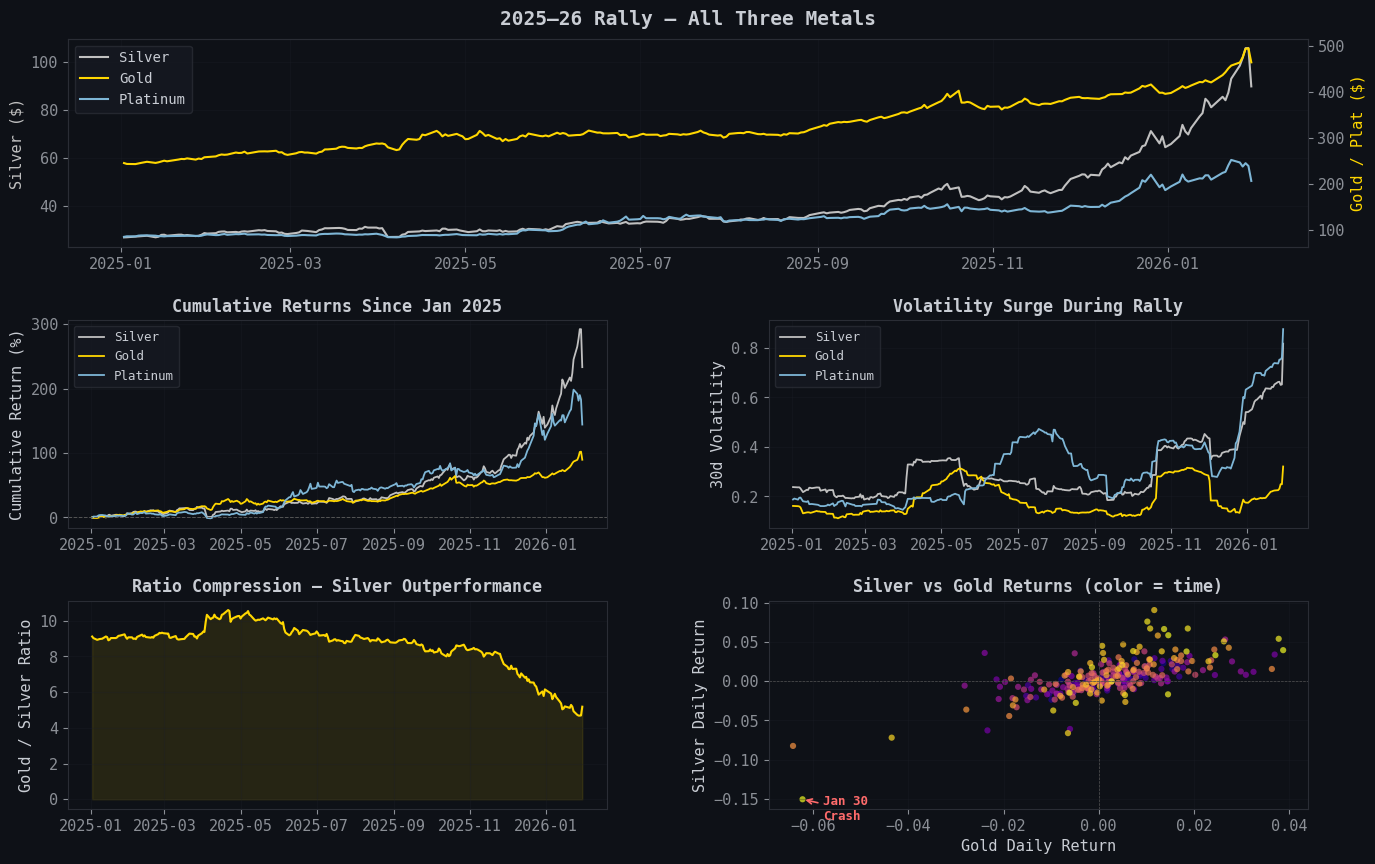

In [16]:
rally = df[df['Date'] >= '2025-01-01'].copy()

fig = plt.figure(figsize=(16, 10))
gs = GridSpec(3, 2, hspace=0.35, wspace=0.3)

# ── Panel 1: Price trajectories ──
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(rally['Date'], rally['Silver_Price'], color=SILVER, linewidth=1.5, label='Silver')
ax1_tw = ax1.twinx()
ax1_tw.plot(rally['Date'], rally['Gold_Price'], color=GOLD, linewidth=1.5, label='Gold')
ax1_tw.plot(rally['Date'], rally['Platinum_Price'], color=PLAT, linewidth=1.5, label='Platinum')
ax1.set_ylabel('Silver ($)', color=SILVER)
ax1_tw.set_ylabel('Gold / Plat ($)', color=GOLD)
ax1.set_title('2025–26 Rally — All Three Metals', fontsize=14, pad=10)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_tw.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', framealpha=0.8)
ax1.grid(True, alpha=0.3)

# ── Panel 2: Cumulative returns from Jan 2025 ──
ax2 = fig.add_subplot(gs[1, 0])
for col, color, name in [('Silver_Price', SILVER, 'Silver'), ('Gold_Price', GOLD, 'Gold'), ('Platinum_Price', PLAT, 'Platinum')]:
    cum_ret = (rally[col] / rally[col].iloc[0] - 1) * 100
    ax2.plot(rally['Date'], cum_ret, color=color, linewidth=1.3, label=name)
ax2.axhline(0, color='#555', linewidth=0.7, linestyle='--')
ax2.set_ylabel('Cumulative Return (%)')
ax2.set_title('Cumulative Returns Since Jan 2025', fontsize=12)
ax2.legend(framealpha=0.8, fontsize=9)
ax2.grid(True, alpha=0.3)

# ── Panel 3: Volatility during rally ──
ax3 = fig.add_subplot(gs[1, 1])
rally_vol = rally.dropna(subset=['Silver_Volatility_30d'])
ax3.plot(rally_vol['Date'], rally_vol['Silver_Volatility_30d'], color=SILVER, linewidth=1.3, label='Silver')
ax3.plot(rally_vol['Date'], rally_vol['Gold_Volatility_30d'], color=GOLD, linewidth=1.3, label='Gold')
ax3.plot(rally_vol['Date'], rally_vol['Platinum_Volatility_30d'], color=PLAT, linewidth=1.3, label='Platinum')
ax3.set_ylabel('30d Volatility')
ax3.set_title('Volatility Surge During Rally', fontsize=12)
ax3.legend(framealpha=0.8, fontsize=9)
ax3.grid(True, alpha=0.3)

# ── Panel 4: Gold-Silver ratio compression ──
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(rally['Date'], rally['Gold_Silver_Ratio'], color=GOLD, linewidth=1.5)
ax4.fill_between(rally['Date'], rally['Gold_Silver_Ratio'], alpha=0.1, color=GOLD)
ax4.set_ylabel('Gold / Silver Ratio')
ax4.set_title('Ratio Compression — Silver Outperformance', fontsize=12)
ax4.grid(True, alpha=0.3)

# ── Panel 5: Daily returns scatter ──
ax5 = fig.add_subplot(gs[2, 1])
rally_r = rally.dropna(subset=['Silver_Returns', 'Gold_Returns'])
scatter = ax5.scatter(rally_r['Gold_Returns'], rally_r['Silver_Returns'], 
                       c=rally_r['Date'].astype(int), cmap='plasma', 
                       s=20, alpha=0.7, edgecolors='none')
ax5.axhline(0, color='#555', linewidth=0.5, linestyle='--')
ax5.axvline(0, color='#555', linewidth=0.5, linestyle='--')
ax5.set_xlabel('Gold Daily Return')
ax5.set_ylabel('Silver Daily Return')
ax5.set_title('Silver vs Gold Returns (color = time)', fontsize=12)
ax5.grid(True, alpha=0.3)

# Add the crash day annotation
crash_day = rally_r[rally_r['Silver_Returns'] == rally_r['Silver_Returns'].min()]
if len(crash_day) > 0:
    ax5.annotate('Jan 30\nCrash', 
                xy=(crash_day['Gold_Returns'].values[0], crash_day['Silver_Returns'].values[0]),
                xytext=(15, -15), textcoords='offset points',
                fontsize=9, color=ACCENT, fontweight='bold',
                arrowprops=dict(arrowstyle='->', color=ACCENT, lw=1.2))

fig.suptitle('', y=1.0)
plt.show()

**What the panels reveal together:**

- **Top panel:** All three metals rallied, but silver led the charge. This isn't a case of silver passively following gold — silver was the driver, with gold playing catch-up.

- **Cumulative returns (middle-left):** Silver's cumulative return from January 2025 dwarfs gold and platinum. We're talking about a multi-hundred-percent move in roughly a year. For context, silver historically returns maybe 5–10% annually. This is a 10+ year move compressed into months.

- **Volatility (middle-right):** Silver's vol ramped steadily through the rally and then spiked further at the end. This is the classic pattern of a climactic move — volatility expands as price accelerates, then explodes during the reversal. Gold's volatility, while elevated, remained much more contained.

- **Ratio compression (bottom-left):** The gold-silver ratio fell steadily throughout the rally, confirming that silver was the dominant force. The ratio bottomed right before the crash — exactly when silver was most overextended.

- **Return scatter (bottom-right):** The scatter shows silver's returns becoming increasingly extreme relative to gold as the rally progressed (dots spreading vertically). And that "Jan 30 Crash" annotation? It's the biggest outlier in the plot; a synchronized selloff where both metals dropped hard, but silver got hit far worse.

## 12 · Extreme Days: Largest Moves in the Dataset
Let's put concrete numbers on the tail events. These are the days that make or break portfolios, the ones that risk models are supposed to capture but often don't. I'm pulling the top 5 best and worst days for each metal.

In [17]:
returns_data = df.dropna(subset=['Silver_Returns']).copy()

print("═══ TOP 10 LARGEST SINGLE-DAY MOVES ═══\n")
for name, col in [('SILVER', 'Silver_Returns'), ('GOLD', 'Gold_Returns'), ('PLATINUM', 'Platinum_Returns')]:
    top = returns_data.nlargest(5, col)[['Date', col]].reset_index(drop=True)
    bot = returns_data.nsmallest(5, col)[['Date', col]].reset_index(drop=True)
    top[col] = (top[col] * 100).round(2)
    bot[col] = (bot[col] * 100).round(2)
    
    print(f"  {name}")
    print(f"    Best days:  {', '.join([f'{r.Date.date()} ({r[col]:+.2f}%)' for _, r in top.iterrows()])}")
    print(f"    Worst days: {', '.join([f'{r.Date.date()} ({r[col]:+.2f}%)' for _, r in bot.iterrows()])}")
    print()

═══ TOP 10 LARGEST SINGLE-DAY MOVES ═══

  SILVER
    Best days:  2022-10-03 (+9.14%), 2025-12-26 (+9.05%), 2020-07-22 (+9.00%), 2020-08-13 (+8.67%), 2020-03-24 (+7.96%)
    Worst days: 2026-01-30 (-15.02%), 2020-08-11 (-13.59%), 2020-03-16 (-12.34%), 2021-02-02 (-8.30%), 2025-10-21 (-8.24%)

  GOLD
    Best days:  2016-06-24 (+4.90%), 2020-03-24 (+4.85%), 2020-03-23 (+4.42%), 2016-02-11 (+4.02%), 2026-01-28 (+3.88%)
    Worst days: 2025-10-21 (-6.43%), 2026-01-30 (-6.23%), 2020-08-11 (-5.37%), 2020-11-09 (-4.43%), 2025-12-29 (-4.35%)

  PLATINUM
    Best days:  2020-03-24 (+11.04%), 2025-12-23 (+8.48%), 2026-01-06 (+7.80%), 2025-12-26 (+7.64%), 2026-01-20 (+7.07%)
    Worst days: 2026-01-30 (-13.66%), 2020-03-16 (-13.43%), 2025-12-29 (-12.43%), 2020-03-12 (-11.78%), 2025-07-30 (-6.78%)



**Notice the clustering.** The extreme days aren't randomly scattered across the decade — they cluster around two periods: March 2020 (COVID) and late 2025/early 2026 (the rally and its reversal). This is volatility clustering in action, and it's why GARCH-family models work: extreme days predict more extreme days.

Also notice the *asymmetry*, the worst days tend to be worse than the best days are good. Silver's worst day (-15.02%) is bigger in magnitude than its best day (+9.14%). This negative skew is a universal feature of financial returns and is particularly pronounced in assets that experience speculative manias followed by crashes.

## 13 · Forecast Assessment: Linear Extrapolation vs. Reality
The dataset includes a small forecast file projecting prices out to April 2026. Before we look at it, let me set expectations: forecasting commodity prices is *extremely* hard. Markets are influenced by central bank decisions, geopolitical events, supply shocks, and speculative flows that are fundamentally unpredictable. Any forecast should be viewed with healthy skepticism.

Let's see what approach was used and whether it holds up to scrutiny.

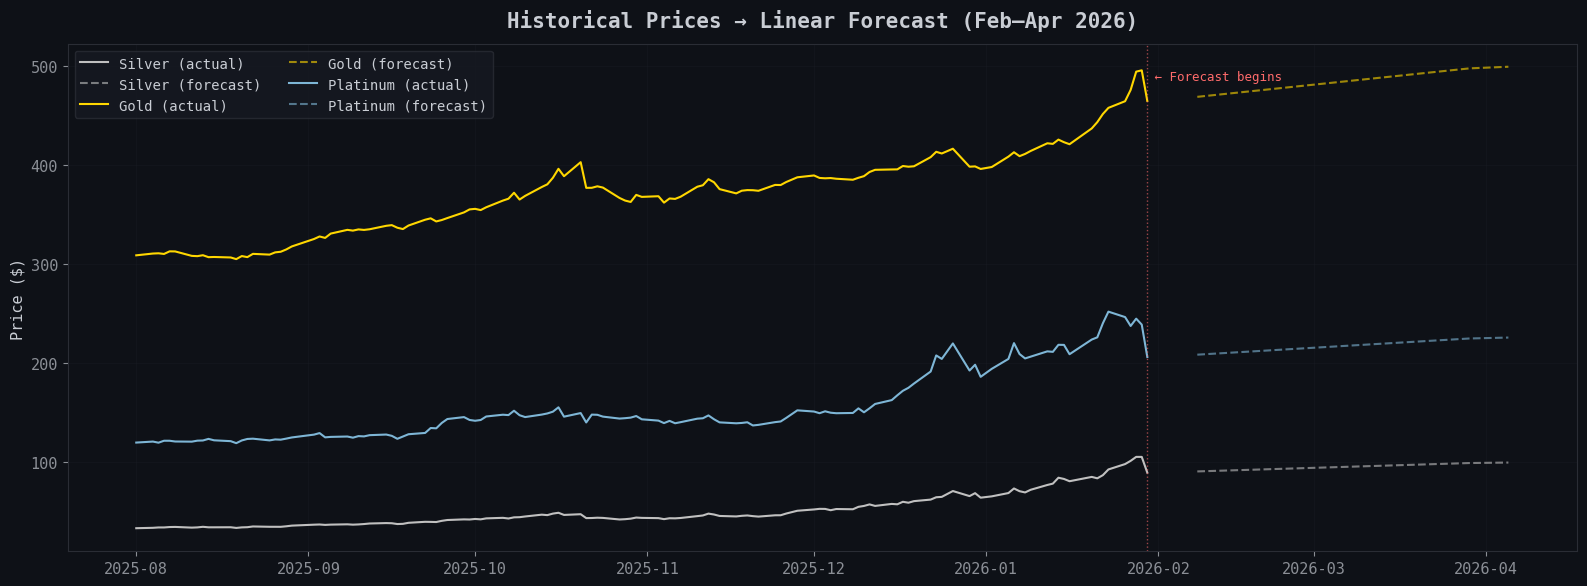

In [18]:
fig, ax = plt.subplots(figsize=(16, 6))

# Last 6 months of historical
recent = df[df['Date'] >= '2025-08-01']

# Silver
ax.plot(recent['Date'], recent['Silver_Price'], color=SILVER, linewidth=1.5, label='Silver (actual)')
ax.plot(fc['Forecast_Date'], fc['Silver'], color=SILVER, linewidth=1.5, linestyle='--', alpha=0.6, label='Silver (forecast)')

# Gold
ax.plot(recent['Date'], recent['Gold_Price'], color=GOLD, linewidth=1.5, label='Gold (actual)')
ax.plot(fc['Forecast_Date'], fc['Gold'], color=GOLD, linewidth=1.5, linestyle='--', alpha=0.6, label='Gold (forecast)')

# Platinum
ax.plot(recent['Date'], recent['Platinum_Price'], color=PLAT, linewidth=1.5, label='Platinum (actual)')
ax.plot(fc['Forecast_Date'], fc['Platinum'], color=PLAT, linewidth=1.5, linestyle='--', alpha=0.6, label='Platinum (forecast)')

# Vertical line at forecast boundary
ax.axvline(df['Date'].max(), color=ACCENT, linewidth=1, linestyle=':', alpha=0.6)
ax.text(df['Date'].max(), ax.get_ylim()[1] * 0.95, ' ← Forecast begins', 
        fontsize=9, color=ACCENT, va='top')

ax.set_title('Historical Prices → Linear Forecast (Feb–Apr 2026)', fontsize=15, pad=12)
ax.legend(loc='upper left', framealpha=0.8, ncol=2)
ax.set_ylabel('Price ($)')
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

In [19]:
print("Forecast Assumptions Check:\n")
for metal in ['Silver', 'Gold', 'Platinum']:
    vals = fc[metal].values
    weekly_change = np.diff(vals)
    print(f"  {metal}: constant weekly increment of ~${weekly_change.mean():.2f}/week")
    print(f"    Forecast range: ${vals[0]:.1f} → ${vals[-1]:.1f}")
    print(f"    Implied annualized growth: {((vals[-1]/vals[0])**(52/len(vals))-1)*100:.1f}%\n")

print("⚠ The forecast is a simple linear extrapolation — it projects continued rally")
print("  momentum with zero volatility. Given the -15% single-day crash on Jan 30,")
print("  these projections likely overestimate prices substantially.")

Forecast Assumptions Check:

  Silver: constant weekly increment of ~$1.12/week
    Forecast range: $90.9 → $99.9
    Implied annualized growth: 72.1%

  Gold: constant weekly increment of ~$3.80/week
    Forecast range: $469.1 → $499.5
    Implied annualized growth: 43.7%

  Platinum: constant weekly increment of ~$2.16/week
    Forecast range: $208.8 → $226.1
    Implied annualized growth: 58.3%

⚠ The forecast is a simple linear extrapolation — it projects continued rally
  momentum with zero volatility. Given the -15% single-day crash on Jan 30,
  these projections likely overestimate prices substantially.


## 14 · Key Takeaways

After going through all of this, here's what I think matters most - the findings that should inform any modeling or further analysis:

1. **The 2025 rally is historic and dominates everything.** Silver appreciated nearly 4x in under a year; a move that dwarfs anything in the prior 8 years of data. Any analysis of this dataset *must* account for this regime shift. Training a model on "the full dataset" without acknowledging the structural break would be a serious methodological error.

2. **Fat tails are real and significant.** All three metals reject normality with extreme kurtosis. The practical implication: risk models that assume Gaussian returns would have badly underestimated the January 30, 2026 crash. If you're building position-sizing or stop-loss logic, use Student's t or empirical distributions, not normal curves.

3. **The gold-silver ratio is at an extreme (~4.7)** and historically extreme readings mean-revert. This is probably the single most actionable signal in the dataset; it suggests silver is overextended relative to gold and that a correction (or gold catch-up) is likely over the medium term.

4. **Volatility regimes are distinct and identifiable.** The 2025–26 vol regime is structurally different from 2016–2024. This isn't just "more of the same but louder" it's a fundamentally different market environment. Regime-aware models (HMM, Markov-switching) would likely outperform regime-blind approaches here.

5. **Correlations aren't constant, they're regime-dependent.** The rolling 90-day silver-gold correlation varies from ~0 to ~0.85. Portfolio diversification between these metals only works in calm markets; in crises, they move together.

6. **The provided linear forecast is naive and already wrong.** It extrapolates rally momentum with zero volatility and constant weekly increments. The January 30 crash (-15% silver) already invalidated its near-term projections. This opens the door for us to build something better.

---

**Where to go from here:**

The natural next steps would be (1) formal regime detection using Hidden Markov Models to label the market states we've visually identified, (2) GARCH volatility modeling to capture the clustering dynamics, and (3) a proper walk-forward forecasting framework that adapts to regime shifts rather than ignoring them. The dataset is well-suited for all three, and the 2025 breakout provides a perfect stress test for any model we build.

*Thanks for reading — feedback and discussion welcome!*